<a href="https://colab.research.google.com/github/VISHAL-0805/Music_genre_classification/blob/main/research_paper_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python_speech_features

!pip install joblib


  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=f57d3b19c579d4c0a42787fb64eb65644f2cecde353665b6700081ac6bb29632
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


In [2]:
!pip install -U kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00


In [3]:
#importing libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import math
import operator
import random
import pickle
import os
import pandas as pd
from python_speech_features import mfcc
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

genre_list = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

In [4]:
#loading dataset and displaying features

data=pd.read_csv("/content/drive/MyDrive/Data/features_30_sec.csv")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [5]:
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
data = data.drop(['filename'],axis=1)

In [7]:
def log_reg_func(X_train, y_train, X_test, y_test, genre):
	logistic_classifier = linear_model.LogisticRegression(max_iter=1000)
	logistic_classifier.fit(X_train, y_train)

	logistic_predictions = logistic_classifier.predict(X_test)
	logistic_accuracy = accuracy_score(y_test, logistic_predictions)

	logistic_cm = confusion_matrix(y_test, logistic_predictions)

	print("Train set accuracy: {:.2f}".format(logistic_classifier.score(X_train, y_train)))
	print("Test set accuracy = " + str(logistic_accuracy))
	joblib.dump(logistic_classifier, 'model.pkl')
	plot_matrix(logistic_cm, "Confusion matrix of Logistic Regression", genre)


In [8]:
 #Function to plot the confusion matrix
def plot_matrix(cm, title, genre):
  df_cm = pd.DataFrame(cm, index = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
                  columns = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
  plt.figure(figsize = (10,7)),	plt.title(title)
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

linear_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['linear'],
}

poly_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['poly'],
}

rbf_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', svm.SVC())
])




In [9]:
#Function to train the model using SVM
def svm_model(params, X_train, y_train, X_test, y_test, title):
  svm = GridSearchCV(pipe_svm, params, scoring='accuracy', cv=5)
  svm.fit(X_train, y_train)
  svm_pred = svm.predict(X_test)

  train_accuracy = svm.score(X_train, y_train)
  test_accuracy = svm.score(X_test, y_test)
  print("Train set accuracy: {:.2f}".format(train_accuracy))
  print("Test set accuracy: {:.2f}".format(test_accuracy))

  svm_cm = confusion_matrix(y_test, svm_pred)

  plot_matrix(svm_cm, title, genre_list)

In [10]:

# Scaling the dataset
# and Label encoding the label (genres)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [11]:
#using knn classifier
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

# Step 7: Make predictions on the test set
y_pred = knn_classifier.predict(X_test_scaled)

# Step 8: Evaluate the KNN classifier
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(accuracy))

Test set accuracy: 0.65


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Train set accuracy: 0.82
Test set accuracy: 0.67
Best n_neighbors: 5


<Axes: title={'center': 'Confusion matrix of KNN'}>

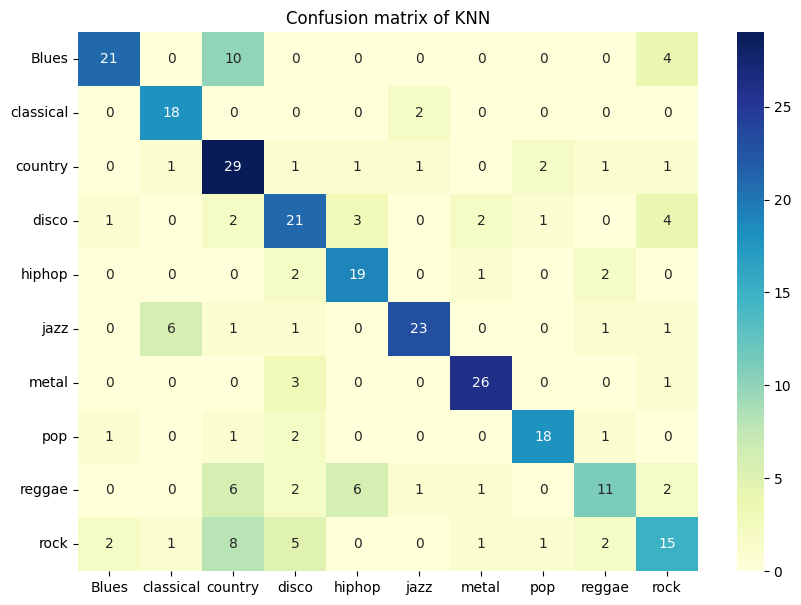

In [12]:
# Apllying GridSearchCV to find the best k value
grid_params = {
    "n_neighbors": [1,3,5,7,9,11,13,15,17],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1,cv=5,n_jobs=-1)

grid_knn.fit(X_train, y_train)
knn_pred = grid_knn.predict(X_test)
print("Train set accuracy: {:.2f}".format(grid_knn.score(X_train, y_train)))
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, knn_pred)))
print('Best n_neighbors:', grid_knn.best_estimator_.get_params()['n_neighbors'])


#ploting the confusion matrix for KNN
grid_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred), index = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
                  columns = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
plt.figure(figsize = (10,7))
plt.title("Confusion matrix of KNN")
sns.heatmap(grid_cm, annot=True, cmap="YlGnBu")